In [4]:
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from os import listdir
from os.path import isfile, join
import re
from tqdm import tqdm
from pylab import text


In [5]:
import cbsodata

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [25]:
# Zoek op welke data beschikbaar is
metadata = pd.DataFrame(cbsodata.get_meta('83765NED', 'DataProperties'))
keys = metadata.Key
keys = keys.loc[keys.str.len() > 0].values
for ii in range(0, len(keys), 3):
    print("".join(["{:40}".format(s) for s in keys[ii:ii+3]]))

WijkenEnBuurten                         Gemeentenaam_1                          SoortRegio_2                            
Codering_3                              IndelingswijzigingWijkenEnBuurten_4     AantalInwoners_5                        
Mannen_6                                Vrouwen_7                               k_0Tot15Jaar_8                          
k_15Tot25Jaar_9                         k_25Tot45Jaar_10                        k_45Tot65Jaar_11                        
k_65JaarOfOuder_12                      Ongehuwd_13                             Gehuwd_14                               
Gescheiden_15                           Verweduwd_16                            WestersTotaal_17                        
NietWestersTotaal_18                    Marokko_19                              NederlandseAntillenEnAruba_20           
Suriname_21                             Turkije_22                              OverigNietWesters_23                    
GeboorteTotaal_24               

In [8]:
#TotaalCBSTabel = pd.DataFrame(cbsodata.get_data('60048NED'))

In [26]:
cbsTabelOrgineel = pd.DataFrame(cbsodata.get_data('60048NED', select = ["Perioden", "RegioS", "k_15Tot20Jaar_93", "k_20Tot25Jaar_94", "k_15Tot20Jaar_162", "k_20Tot25Jaar_163"]))
cbsTabelOrgineel = cbsTabelOrgineel.rename(columns = {"k_15Tot20Jaar_93": "Gevestigd_15_20", 
                                                      "k_20Tot25Jaar_94": "Gevestigd_20_25", 
                                                      "k_15Tot20Jaar_162": "Vertrokken_15_20", 
                                                      "k_20Tot25Jaar_163": "Vertrokken_20_25"})
cbsTabelOrgineel["Vertrokken"] = cbsTabelOrgineel.Vertrokken_15_20 + cbsTabelOrgineel.Vertrokken_20_25
cbsTabelOrgineel["Gevestigd"] = cbsTabelOrgineel.Gevestigd_15_20 + cbsTabelOrgineel.Gevestigd_20_25
cbsTabelOrgineel.head()

,Perioden,RegioS,Gevestigd_15_20,Gevestigd_20_25,Vertrokken_15_20,Vertrokken_20_25,Vertrokken,Gevestigd
0,1988,Nederland,58151.0,132599.0,58151.0,132599.0,190750.0,190750.0
1,1989,Nederland,57134.0,137107.0,57134.0,137107.0,194241.0,194241.0
2,1990,Nederland,53024.0,131743.0,53024.0,131743.0,184767.0,184767.0
3,1991,Nederland,50282.0,129663.0,50282.0,129663.0,179945.0,179945.0
4,1992,Nederland,47487.0,129569.0,47487.0,129569.0,177056.0,177056.0


In [27]:
dfStudenten = pd.read_csv("VerhuisdePersonen15-25.csv", sep = ";")
dfStudenten = dfStudenten.dropna()
dfStudenten = dfStudenten.rename(columns = {"Regio's": "Regio"})

In [28]:
cbsTabel = cbsTabelOrgineel.loc[cbsTabelOrgineel.RegioS.isin(dfStudenten.Regio), :]
cbsTabel = cbsTabel.loc[cbsTabel.Perioden.astype(int) >= 2010, :]
cbsTabel = cbsTabel.dropna()

regex = re.compile(" \((.*?)\)")
cond = cbsTabel.RegioS.str[:6] != "Bergen"
cbsTabel.RegioS[cond] = cbsTabel.RegioS[cond].str.replace(regex, "")

cbsTabel.Gevestigd = cbsTabel.Gevestigd
cbsTabel.Vertrokken = cbsTabel.Vertrokken
cbsTabel["Netto"] = cbsTabel.Gevestigd - cbsTabel.Vertrokken

cbsTabel = cbsTabel.sort_values(by = "Gevestigd", ascending = False)
cbsTabel.head()

,Perioden,RegioS,Gevestigd_15_20,Gevestigd_20_25,Vertrokken_15_20,Vertrokken_20_25,Vertrokken,Gevestigd,Netto
2777,2013,Amsterdam,3855.0,11703.0,1365.0,6290.0,7655.0,15558.0,7903.0
2778,2014,Amsterdam,3678.0,11580.0,1469.0,6668.0,8137.0,15258.0,7121.0
2779,2015,Amsterdam,3080.0,12088.0,1301.0,6785.0,8086.0,15168.0,7082.0
2776,2012,Amsterdam,3786.0,11289.0,1344.0,6373.0,7717.0,15075.0,7358.0
2780,2016,Amsterdam,2677.0,11460.0,1252.0,6630.0,7882.0,14137.0,6255.0


In [29]:
jaar = 2018
file = "GemeenteGrenzen{}.geojson".format(jaar)
gemeentegrenzen = gpd.read_file("grenzen/" + file, driver = "GeoJSON")
gemeenteData = pd.merge(gemeentegrenzen, cbsTabel.loc[cbsTabel.Perioden.astype(int) == jaar, :],
                           left_on = "statnaam", 
                           right_on = "RegioS",
                       how = "outer")

In [30]:
gemeenteData.columns

Index(['id', 'statcode', 'jrstatcode', 'statnaam', 'rubriek', 'geometry',
       'Perioden', 'RegioS', 'Gevestigd_15_20', 'Gevestigd_20_25',
       'Vertrokken_15_20', 'Vertrokken_20_25', 'Vertrokken', 'Gevestigd',
       'Netto'],
      dtype='object')

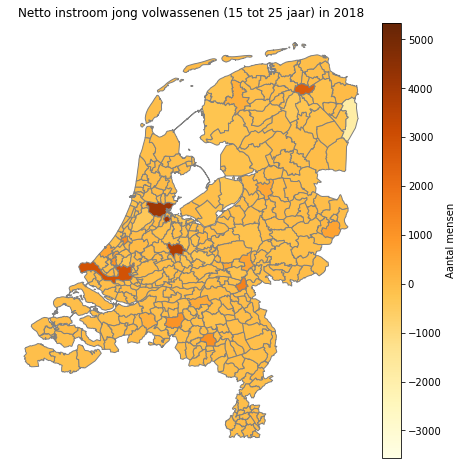

In [32]:
cmap = cm.get_cmap('YlOrBr')# wissel tussen Accent en YlOrBr

gemeenteData.Netto = gemeenteData.Netto.fillna(0)
data = gemeenteData.groupby("statnaam").sum()

vmin = cbsTabel.Netto.min()
vmax = vmin*-1.5 # cbsTabel.Netto.max()



# Maak een thematische kaart
p1 = gemeenteData.plot(column='Netto', 
                       figsize = (10,8),
                       edgecolor = "grey",
                       cmap = cmap,
                       vmin = vmin,
                       vmax = vmax)
p1.axis('off')
p1.set_title("Netto instroom jong volwassenen (15 tot 25 jaar) in {}".format(jaar))
divider2 = make_axes_locatable(p1)
cax2 = divider2.append_axes("right", size="5%", pad=0.1)

sm = cm.ScalarMappable(cmap= cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbr = plt.colorbar(sm, cax = cax2, ax = p1)
cbr.set_label("Aantal mensen")

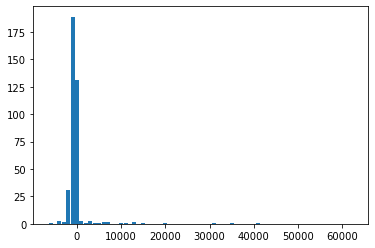

In [57]:
ax = plt.hist(gemeenteData.Netto, rwidth = 0.9, bins = range(int(gemeenteData.Netto.min()), int(gemeenteData.Netto.max()), 1000))

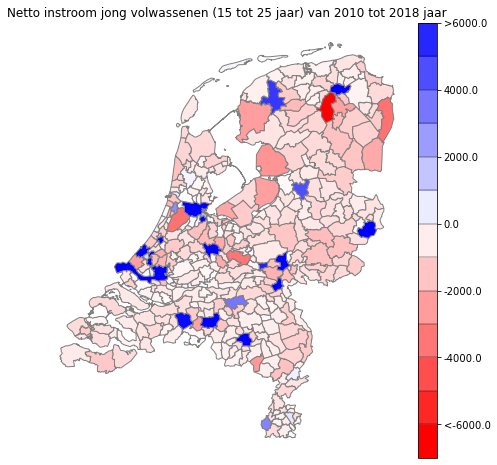

In [93]:
somNetto = cbsTabel.groupby("RegioS").sum()
gemeenteData = pd.merge(gemeentegrenzen, somNetto,
                           left_on = "statnaam", 
                           right_on = "RegioS",
                       how = "outer")

cmap = cm.get_cmap('bwr_r')
vmin = gemeenteData.Netto.min()
vmax = -vmin


# Maak een thematische kaart
p1 = gemeenteData.plot(column='Netto', 
                       figsize = (10,8),
                       edgecolor = "grey",
                       cmap = cmap,
                       vmin = vmin,
                       vmax = vmax)
p1.axis('off')
p1.set_title("Netto instroom jong volwassenen (15 tot 25 jaar) van 2010 tot 2018 jaar")
divider2 = make_axes_locatable(p1)
cax2 = divider2.append_axes("right", size="5%", pad=0.1)

sm = cm.ScalarMappable(cmap= cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbr = plt.colorbar(sm, cax = cax2, ax = p1, drawedges = True, boundaries = range(round(vmin/1000)*1000, int(vmax), 1000))

ticklabels = []
for ii, tick in enumerate(cbr.get_ticks()):
    if ii == 0:
        add = "<"
    elif ii == len(cbr.get_ticks())-1:
        add = ">"
    else:
        add = ""
    ticklabels.append(f"{add}{tick}")
    
    
cbr.set_ticklabels(ticklabels)

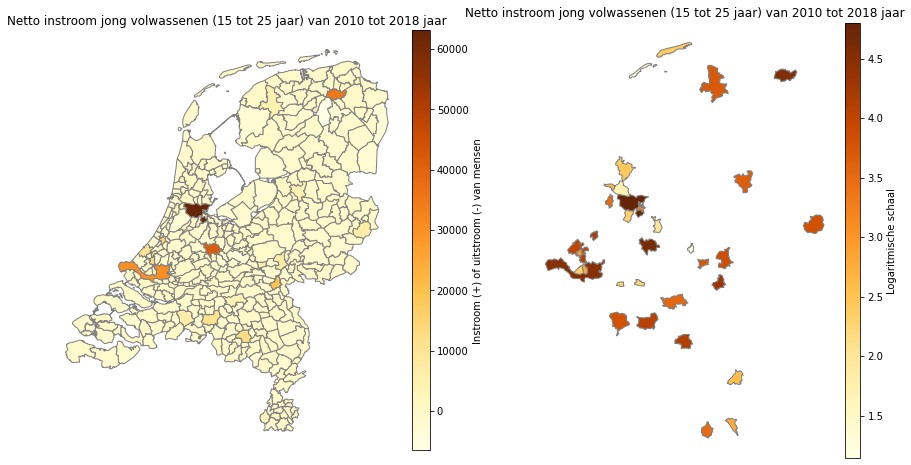

In [34]:
somNetto = cbsTabel.groupby("RegioS").sum()
gemeenteData = pd.merge(gemeentegrenzen, somNetto,
                           left_on = "statnaam", 
                           right_on = "RegioS",
                       how = "outer")

cmap = cm.get_cmap('YlOrBr')# wissel tussen Accent en YlOrBr
vmin = gemeenteData.Netto.min()
vmax = gemeenteData.Netto.max()

fig, axes = mpl.pyplot.subplots(ncols=2, figsize = [15, 8])

# Maak een thematische kaart
p1 = gemeenteData.plot(ax = axes[0],
                       column='Netto', 
                       figsize = (10,8),
                       edgecolor = "grey",
                       cmap = cmap,
                       vmin = vmin,
                       vmax = vmax)
p1.axis('off')
p1.set_title("Netto instroom jong volwassenen (15 tot 25 jaar) van 2010 tot 2018 jaar")
divider2 = make_axes_locatable(p1)
cax2 = divider2.append_axes("right", size="5%", pad=0.1)

sm = cm.ScalarMappable(cmap= cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbr = plt.colorbar(sm, cax = cax2, ax = p1)
cbr.set_label("Instroom (+) of uitstroom (-) van mensen")

logSomNetto = np.log10(cbsTabel.groupby("RegioS").sum())
gemeenteData = pd.merge(gemeentegrenzen, logSomNetto,
                           left_on = "statnaam", 
                           right_on = "RegioS",
                       how = "outer")

cmap = cm.get_cmap('YlOrBr')# wissel tussen Accent en YlOrBr
vmin = gemeenteData.Netto.min()
vmax = gemeenteData.Netto.max()



# Maak een thematische kaart
p1 = gemeenteData.plot(ax = axes[1],
                       column='Netto', 
                       figsize = (10,8),
                       edgecolor = "grey",
                       cmap = cmap,
                       vmin = vmin,
                       vmax = vmax)
p1.axis('off')
p1.set_title("Netto instroom jong volwassenen (15 tot 25 jaar) van 2010 tot 2018 jaar")
divider2 = make_axes_locatable(p1)
cax2 = divider2.append_axes("right", size="5%", pad=0.1)

sm = cm.ScalarMappable(cmap= cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbr = plt.colorbar(sm, cax = cax2, ax = p1)
cbr.set_label("Logaritmische schaal")

In [13]:
fig.savefig("Netto jong volwassenstroom 10-18.pdf", quality = 95, format = "pdf")

In [14]:
gemeentePopulatie = pd.read_csv("Bevolkingsontwikkeling.csv", sep = ";")
gemeentePopulatie = gemeentePopulatie.loc[:, ~gemeentePopulatie.columns.isin(["Onderwerp", "Unnamed: 2"])]
gemeentePopulatie = gemeentePopulatie.dropna()
gemeentePopulatie = gemeentePopulatie.rename(columns = {"Regio's": "RegioS"}) 
regex = re.compile(" \((.*?)\)")
cond = gemeentePopulatie.RegioS.str[:6] != "Bergen"
gemeentePopulatie.RegioS[cond] = gemeentePopulatie.RegioS[cond].str.replace(regex, "")

In [30]:
somNetto["NettoPercent"] = 0

for regio in somNetto.index:
    cond = (somNetto.index == regio).astype(bool)
    netto = somNetto.loc[cond, "Netto"].values
    populatie = gemeentePopulatie.loc[gemeentePopulatie.RegioS == regio, "2018"].values
    
    if len(populatie) == 0:
        print(regio)
        continue
    somNetto.loc[cond, "NettoPercent"] = netto/populatie * 100
    

Berg en Dal
Bodegraven-Reeuwijk
De Fryske Marren
Eijsden-Margraten
Goeree-Overflakkee
Gooise Meren
Hollands Kroon
Krimpenerwaard
Meierijstad
Midden-Groningen
Molenwaard
Nissewaard
Stichtse Vecht
Súdwest-Fryslân
Waadhoeke
Westerwolde


In [32]:
somNetto.sort_values(by = "NettoPercent", ascending= False).head()

,Vertrokken_15_20,Gevestigd_15_20,Vertrokken_20_25,Gevestigd_20_25,Vertrokken,Gevestigd,Netto,NettoPercent
RegioS,,,,,,,,
Groningen,6627.0,35073.0,42601.0,46610.0,49228.0,81683.0,32455.0,16.002663
Wageningen,1785.0,6110.0,6988.0,7663.0,8773.0,13773.0,5000.0,13.016766
Delft,2917.0,11954.0,12014.0,14973.0,14931.0,26927.0,11996.0,11.731685
Leiden,3276.0,12098.0,15241.0,20620.0,18517.0,32718.0,14201.0,11.424227
Utrecht,7602.0,25757.0,39886.0,60057.0,47488.0,85814.0,38326.0,11.029604


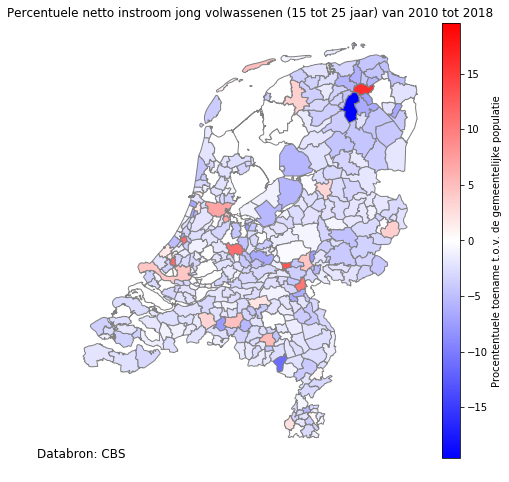

In [80]:
gemeenteData = pd.merge(gemeentegrenzen, somNetto,
                           left_on = "statnaam", 
                           right_on = "RegioS",
                       how = "outer")

cmap = cm.get_cmap('bwr')# wissel tussen Accent en YlOrBr
vmin = gemeenteData.NettoPercent.min()
vmax = -1* vmin# gemeenteData.NettoPercent.max()

# Maak een thematische kaart
p1 = gemeenteData.plot(column='NettoPercent', 
                       figsize = (10,8),
                       edgecolor = "grey",
                       cmap = cmap,
                       vmin = vmin,
                       vmax = vmax)
p1.axis('off')
p1.set_title("Percentuele netto instroom jong volwassenen (15 tot 25 jaar) van 2010 tot 2018")

divider2 = make_axes_locatable(p1)
cax2 = divider2.append_axes("right", size="5%", pad=0.1)
text(-22, 0, "Databron: CBS", fontsize=12)
sm = cm.ScalarMappable(cmap= cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbr = plt.colorbar(sm, cax = cax2, ax = p1)
cbr.set_label("Procententuele toename t.o.v. de gemeentelijke populatie")